# ENIGMA Explorer API Examples

## Phylogenic Tree of FW305-130 relatives

In [2]:
import requests

ISOLATE_ID = "FW305-130"
BASE_URL = "http://isolates.genomics.lbl.gov/api/v1"

# Search for the id of this isolate
idUrl = BASE_URL+"/isolates/isoid/" + ISOLATE_ID
idRes = requests.get(idUrl)
if idRes.status_code != 200 :
    print("Error in getting id:", idRes.status_code, idRes.json()["message"])
    raise KeyboardInterrupt
else :
    idJson = idRes.json()
    myId = idJson["id"]
    print('Id of', ISOLATE_ID, 'is', myId)

# Retrieve the top 50 BLAST hits of its 16s sequence
bUrl = BASE_URL+"/ncbi/blast/isolates/" + str(myId)
bRes = requests.get(bUrl)
if bRes.status_code != 200 :
    print("Error in BLAST:", bRes.status_code, bRes.json()["message"])
    raise KeyboardInterrupt
else :
    bJson = bRes.json()
    hits = [ j["isoid"] for j in bJson ]

# Again, use /isolates/isoid to get the 16s seq
rrnas = []
for hit in hits :
    rUrl = BASE_URL+"/isolates/isoid/" + hit
    rRes = requests.get(rUrl)
    rJson = rRes.json()
    # Some isolates do not have 16s seq
    if "rrna" not in rJson :
        hits.remove(hit)
        continue
    rrnas.append(rJson["rrna"])
# Write rrnas to fasta
path = "hits.fasta"
fo = open(path, 'w')
for hit, rrna in zip(hits[:20], rrnas[:20]) :
    if rrna == "" :
        continue
    fo.write('>' + hit + '\n')
    fo.write(rrna + '\n')
fo.close()
    

Id of FW305-130 is 1


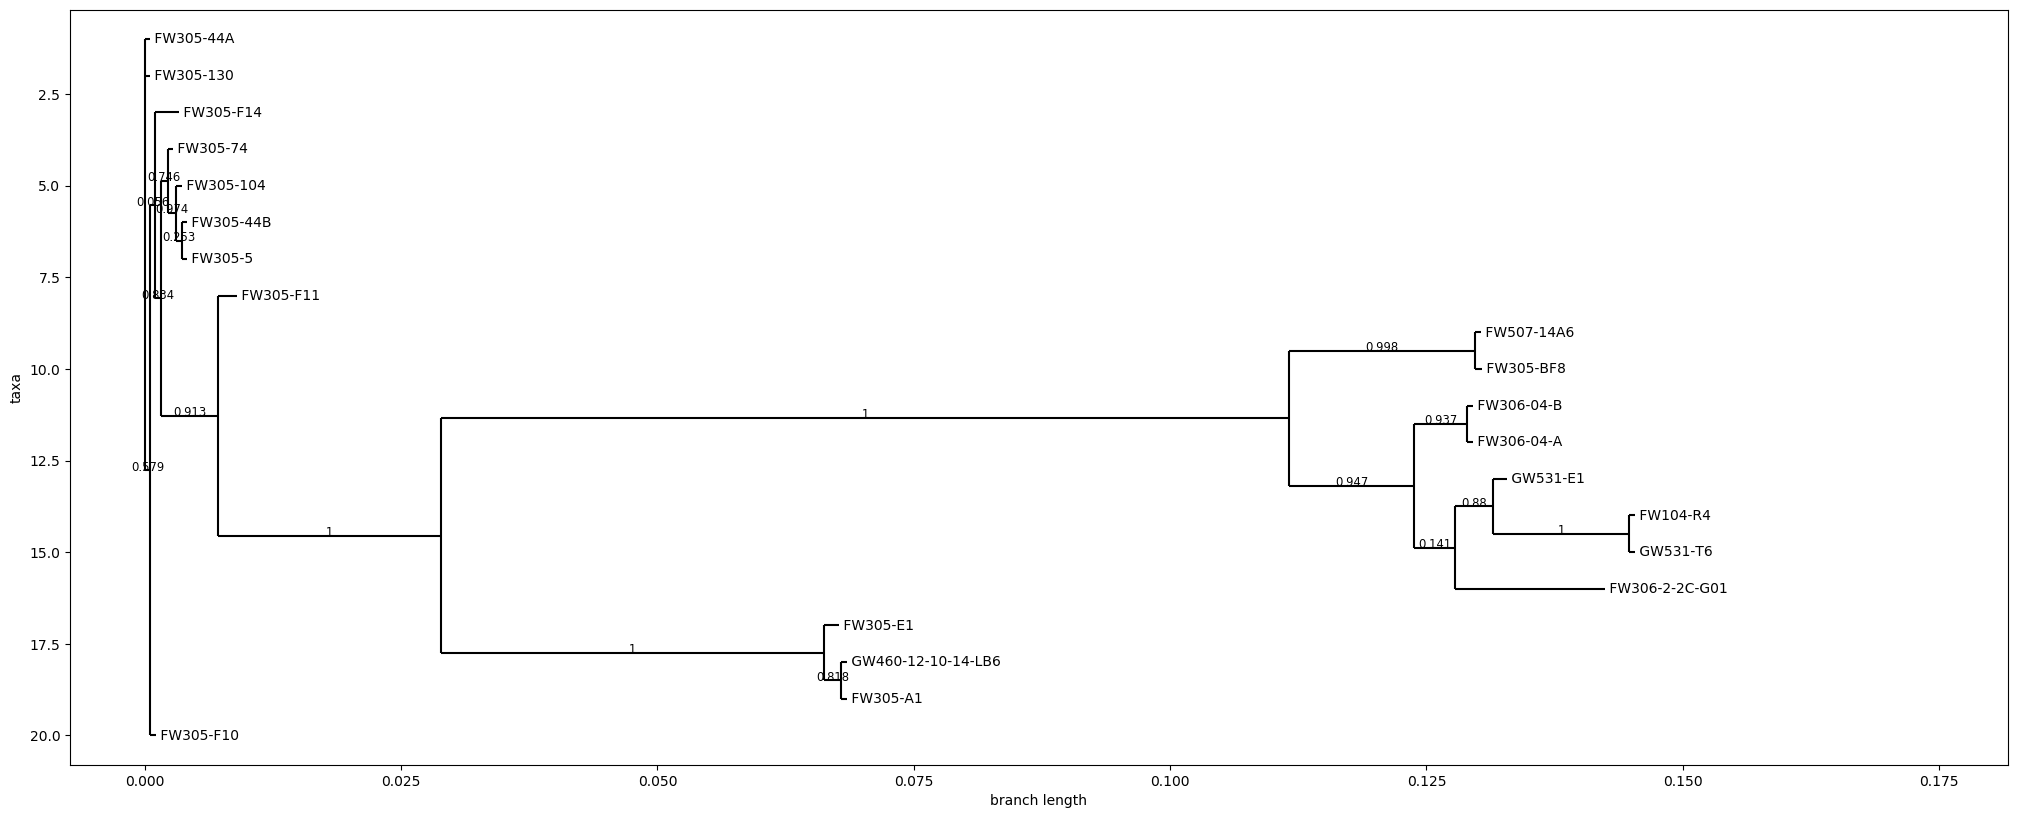

In [5]:
%matplotlib inline
from Bio import Phylo
import matplotlib.pyplot as plt

tree = Phylo.read('hits.nwk', 'newick')
# set tree size
fig = plt.figure(figsize=(25, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

## Xcc Growth Curve Measurement

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import numpy as np

def myplot(id, curveGroups, curveLegends, axis) :
    # Retrieve curve values
    BASE_URL = 'http://isolates.genomics.lbl.gov/api/v1'
    res = requests.get(BASE_URL + '/growth/wells/id/' + str(id))
    # Handle errors
    if res.status_code != 200 :
        print('Error:', res.status_code, res.json()['message'])
    else :
        json = res.json()
        # Forsake the 1st timepoint due to unstable measurement
        timepoints = [ x/3600 for x in json[0]['data']['timepoints'] ][1:]
        for group, legend in zip(curveGroups, curveLegends) :
            values = [ json[i]['data']['values'][1:] for i in group ]
            means = [  np.mean(v) for v in zip(*values) ]
            stds = [ np.std(v, ddof=1) for v in zip(*values) ]
            axis.plot(timepoints, means)
            # Std err lines
            axis.fill_between(timepoints, [m+s for m,s in zip(means,stds)], [m-s for m,s in zip(means,stds)],
                             label = legend, alpha=0.5)
            axis.legend(loc='upper left')
            axis.set_xlabel('Time (hour)')
            axis.set_ylabel('OD 600')

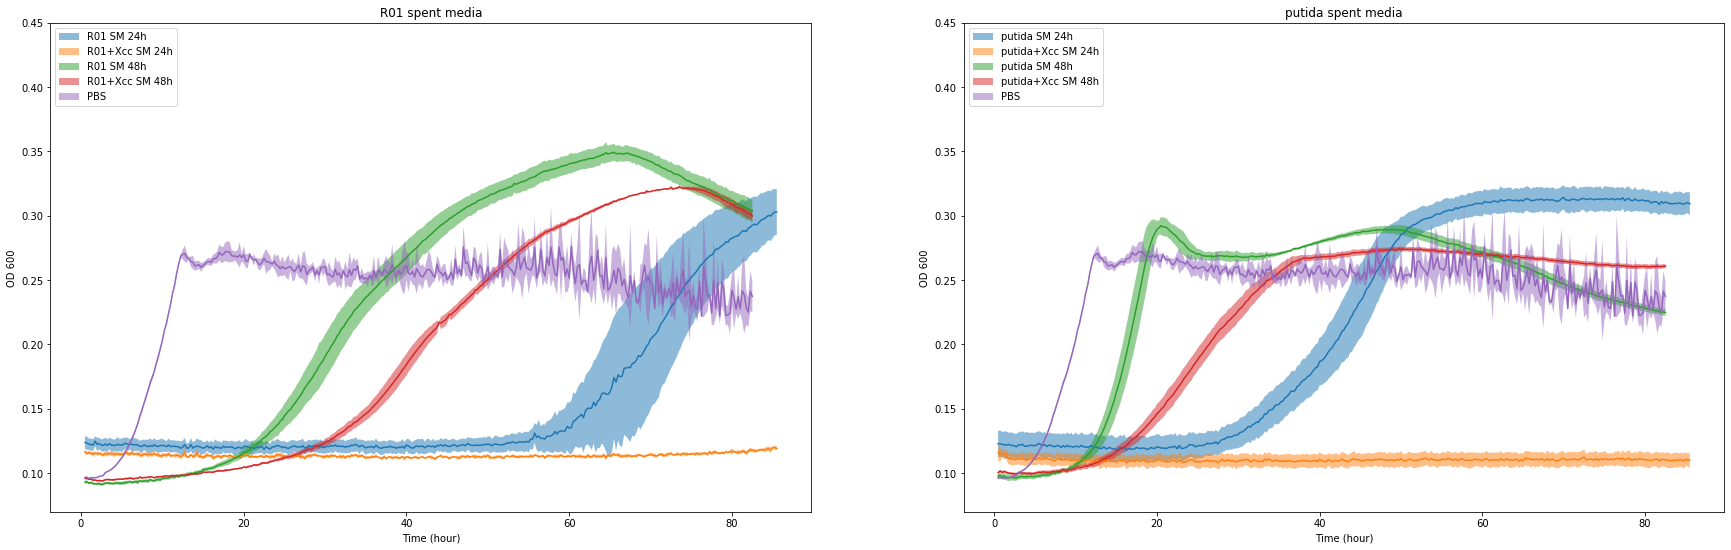

In [5]:
# Initialize canvas
f, axes = plt.subplots(1,2, figsize=(30,9))

myplot(2072, [[0,8,16], [48,56,64]], ['R01 SM 24h', 'R01+Xcc SM 24h'], axes[0])
myplot(2073, [[0,8,16], [24,32,40], [7, 15, 23]], ['R01 SM 48h', 'R01+Xcc SM 48h', 'PBS'], axes[0])
axes[0].set_title('R01 spent media')
axes[0].set_ylim(0.07, 0.45)

myplot(2072, [[24,32,40], [72,80,88]], ['putida SM 24h', 'putida+Xcc SM 24h'], axes[1])
myplot(2073, [[48,56,64], [72,80,88], [7, 15, 23]], ['putida SM 48h', 'putida+Xcc SM 48h', 'PBS'], axes[1])
axes[1].set_title('putida spent media')
_ = axes[1].set_ylim(0.07, 0.45)